# Fraud Detection

<b>
1) For each user, determine her country based on the numeric IP address.
</b>

A new column "country" was added to the Fraud_Data column if the ip_address fell within the lower and upper bounds (inclusive) for a country.

<b>
2) Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
</b>

High false positives indicate that more good users are interrupted when their transactions are marked as fraudulent. These users may become agitated and churn. High false negatives mean that more fradulent transactions are not caught. These transcations are losing money for the company. 

<b>
3) Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
</b>

The most important variable for predicting fraud is the source. It may be that some sources are easier to commit fraud through. It may be useful to have different thresholds for declaring fraud for different sources.
<br><br>
The second most important variables for predicting fraud are a higher number of transactions from the same ip address (with different user ids). This is also correlated with device id (with different user ids). 
<b>

4) Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?
</b>

A) if P(Fraud) < X, the user has a typical experience<br>
B) if X <= P(Fraud) < Z, the user has a second verification step (verify phone number)<br>
C) if P(Fraud >= Z, the user is referred to a person to manually verify the account<br>


In [84]:
#import packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
palette = sns.color_palette()
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from itertools import cycle
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from scipy import interp
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from scipy.stats import ttest_ind


<b>
Imported Data
</b>

I imported data from the Fraud_Data csv file. This data consisted of 151,112 samples with 11 features.

I also imported data from the IpAddress_to_Country csv file. This data consists of 138,846 from 235 countries.

In [14]:
#import fraud data
url = 'Fraud_Data.csv'
data = pd.read_csv(url)
data.describe()

#import ip address to country data
url = 'IpAddress_to_Country.csv'
ipdata = pd.read_csv(url)
ipdata = ipdata.as_matrix()

#connect fraud data to country
country = []
for ip in data['ip_address']:
    c = ipdata[np.add((ipdata[:,0] <= ip), (ipdata[:,1] >= ip), dtype=np.float) == 2, 2]
    if len(c) == 1:
        country.append(c)
    else:
        country.append(None)
data['country'] = country
data['country'] = data['country'].astype(str)

<b>
Preprocessed Data:
</b>

1) Checked for duplicate rows. Duplicate rows are likely to be the same person entered twice and not separate entries. 

2) Dropped rows missing data. An alternative to dropping this row would be to infer the missing value using the mean value of the column. There was 1 row with non-numeric or missing data. 

3) Drop unique identifiers.

4) Convert binary data to 1s and 0s.

5) Create new features. Include time since sign up by subtracting sign up time from purchase time. Include frequncy of each user id, device id and ip address to see how many times each is used.

6) Check if continuous or binary features are correlated. We can improve model performance by removing correlated variables. An alternative to removing the column would be to perform principal component analysis, but we lose interpretability.

7) Visualize data. What does the distribution look like? Are some features categorical?

8) Convert categorical data to dummy variables

<br>
<b>
With more time I would consider the following pre-processing steps:
</b>

9) Transform non-normal features. We can improve models by normalizing features.

10) Identify and remove outliers

                purchase_value       age      time  ip_count  device_count
purchase_value        1.000000  0.002370  0.003441  0.003266      0.003829
age                   0.002370  1.000000 -0.000575  0.012170      0.012160
time                  0.003441 -0.000575  1.000000 -0.335052     -0.331897
ip_count              0.003266  0.012170 -0.335052  1.000000      0.991083
device_count          0.003829  0.012160 -0.331897  0.991083      1.000000


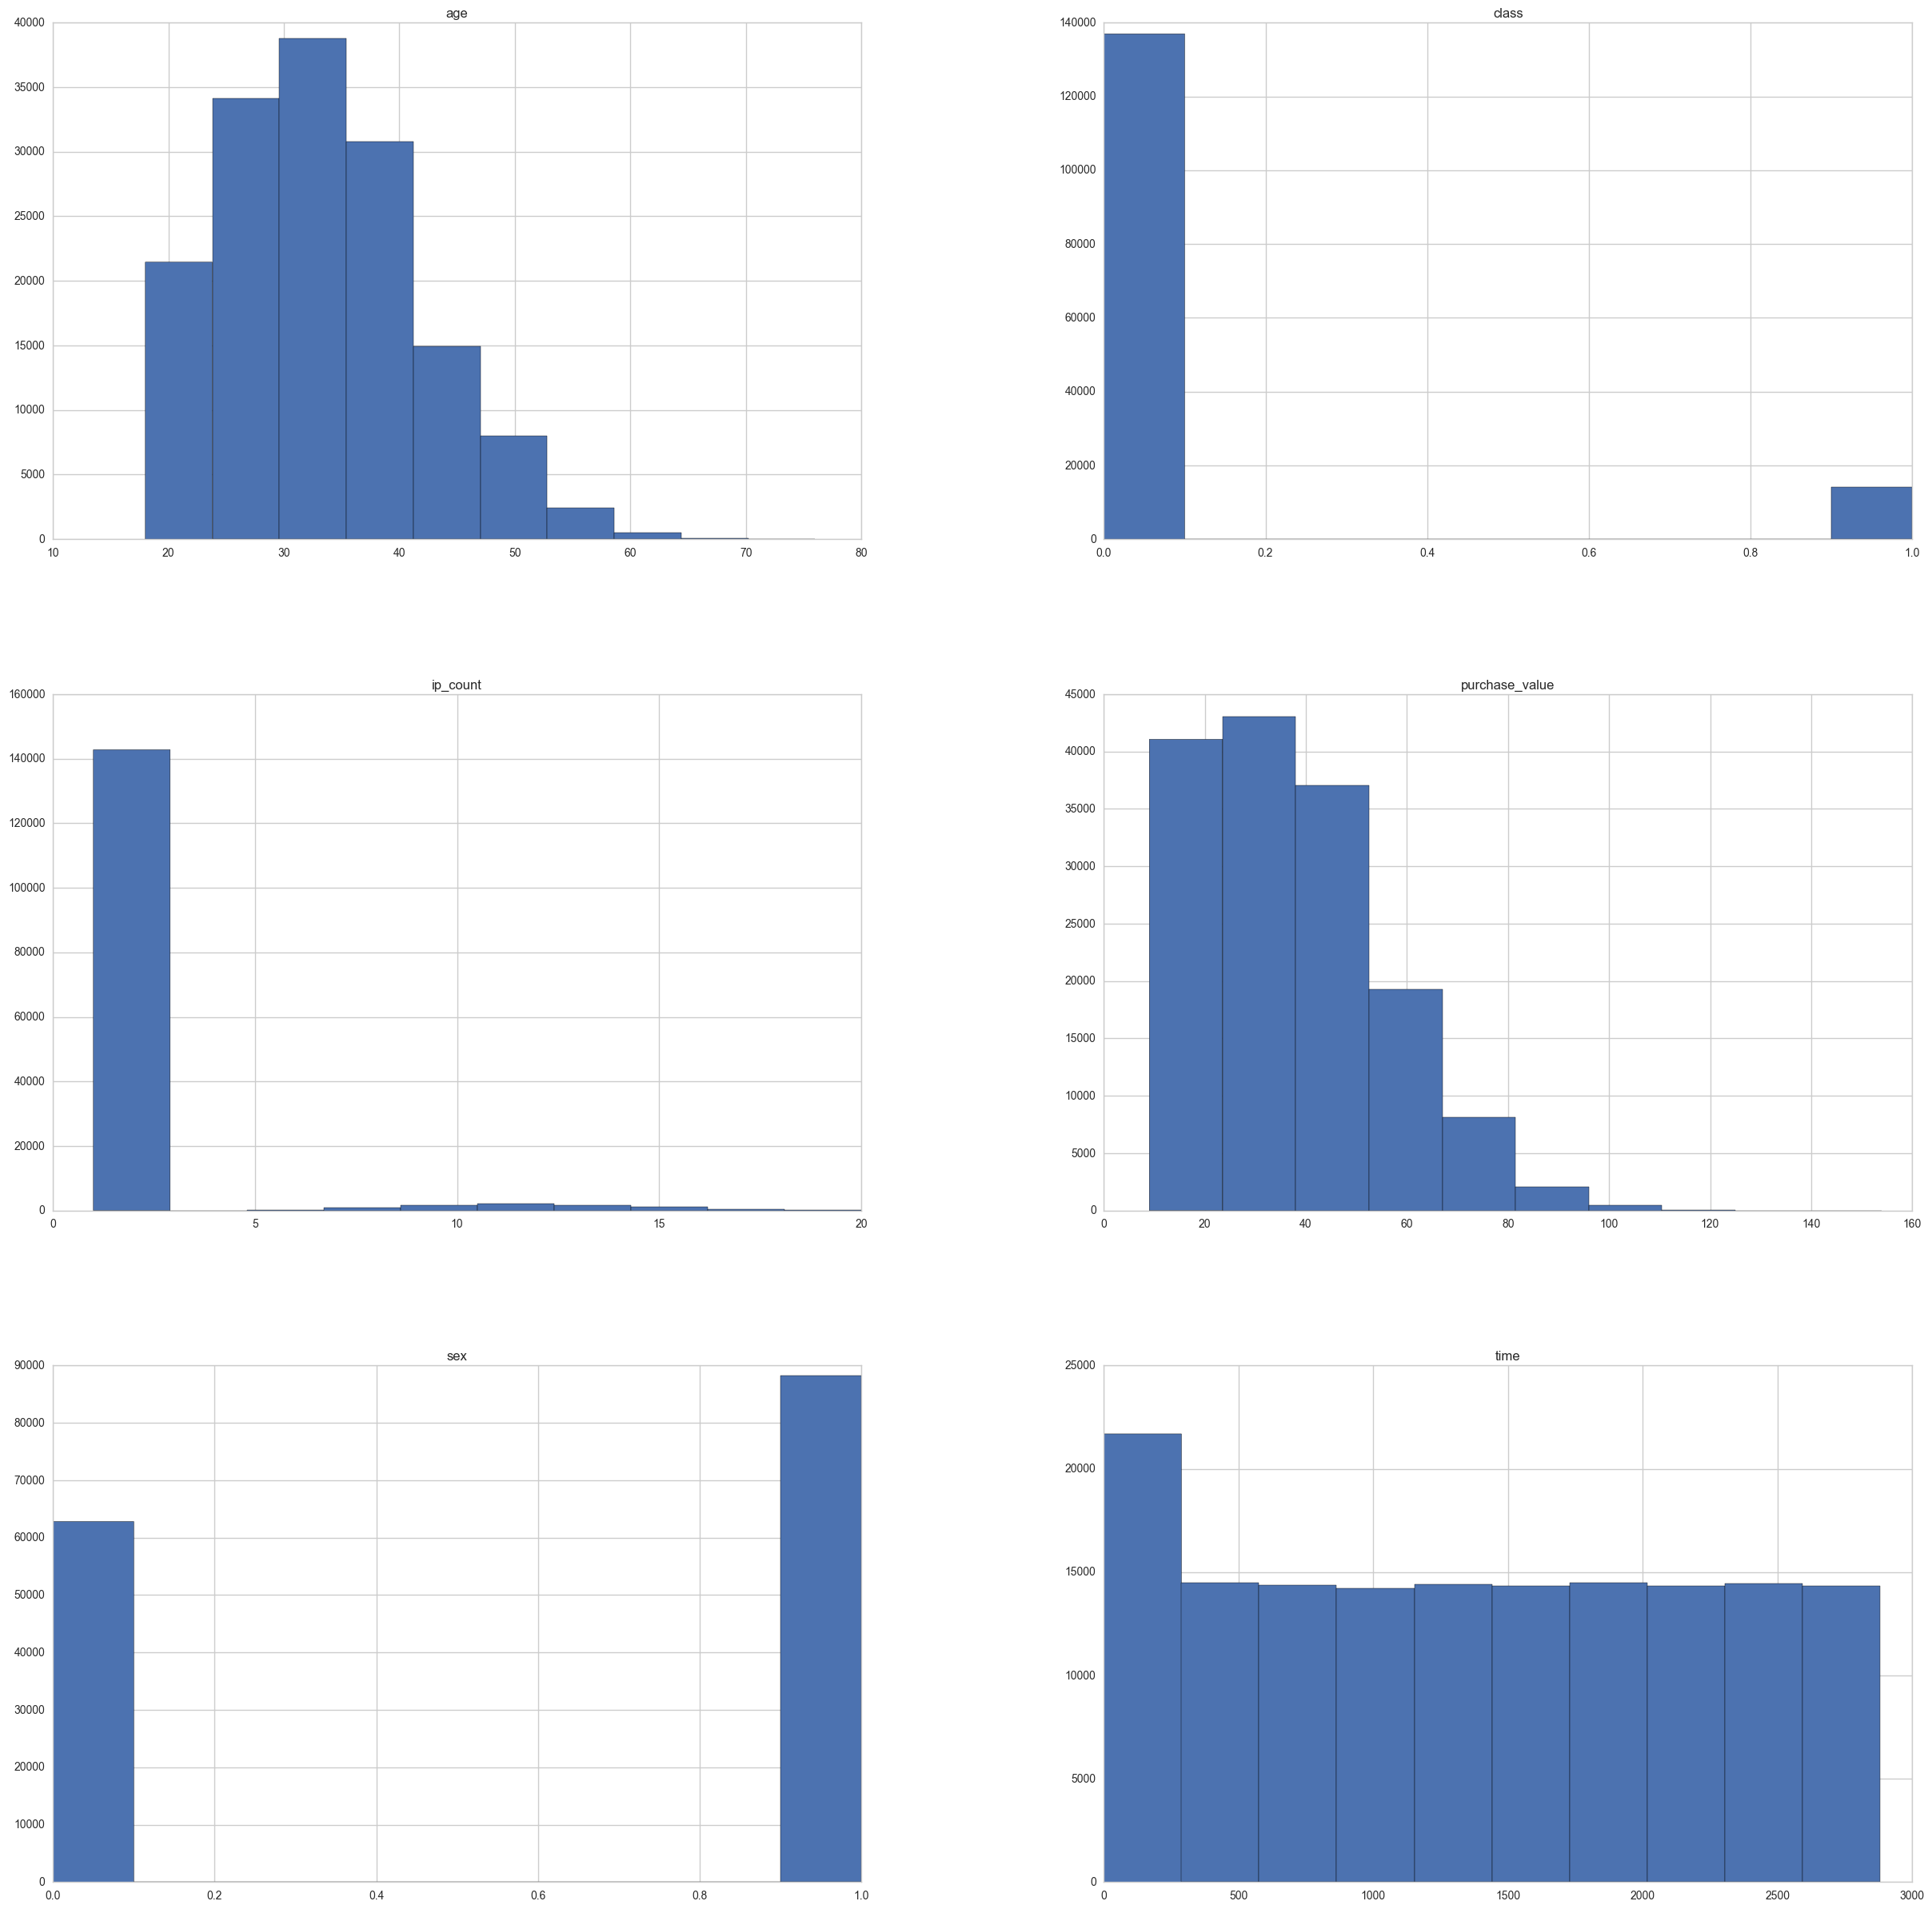

In [78]:
#drop duplicate rows
df = data
df['country'] = df['country'].astype(str)
df = df.drop_duplicates()

#drop rows with missing values
df = df.dropna()

#drop unique identifiers
df = df.drop('user_id', axis=1)
df = df.drop('country', axis=1)

#convert to binary 
for col in ['class', 'sex']:
    dummy = pd.get_dummies(df[col]).astype(int)
    df[col] = dummy.ix[:,1]
    
#create new features
#time since signup
df['time'] = (pd.to_datetime(df['purchase_time'])-pd.to_datetime(df['signup_time']))/np.timedelta64(1, 'h')
df = df.drop('purchase_time', axis=1)
df = df.drop('signup_time', axis=1)
#multiple users
df['device_count'] = df.groupby(['device_id'])['device_id'].transform('count')
df['ip_count'] = df.groupby(['ip_address'])['ip_address'].transform('count')
df = df.drop('device_id', axis=1)
df = df.drop('ip_address', axis=1)

#drop one of two correlated features
da = df[['purchase_value', 'age', 'time', 'ip_count', 'device_count']]
cor = da.astype('float64').corr()
print(cor)
df = df.drop('device_count', axis=1)

#visualize histograms
df[df.columns].hist(figsize=(30,30))

#convert to categorical data to dummy columns
for col in ['source', 'browser']:
    df[col] = df[col].astype('category')
df = pd.get_dummies(df)
df = df.apply(pd.to_numeric, errors='coerce')


<b> 
Split Data 
</b>

I randomly split data into independent training and test sets. The split was 70/30 between the training and test sets.

In [79]:
Y = df['class']
X = df.drop(['class'], axis=1)
X = X.as_matrix()

#split data on unique ids
rs = ShuffleSplit(n_splits=2, test_size=.30, random_state=0)
for train_index, test_index in rs.split(X):
            X_train, X_test = X[train_index,:], X[test_index,:]
            Y_train, Y_test = Y[train_index], Y[test_index]


<b>
Model selection
</b>

I built two models: logistic regression + lasso and random forest. I changed the class weights to account for the imbalanced data set.

The area under the curve for logistic regression + lasso (AUC = 0.77) is higher than that of random forest (AUC = 0.77). The two models perform similarly.

<br>
<b>
With more time, I would do the following to improve model performance.
</b>

1) Optimize parameters <br><br>
2) Feature selection for random forest <br><br>
3) Test more models <br><br>

In [80]:
#Logistic Regression + Lasso 
clf = linear_model.LogisticRegression(C=1, penalty='l1', tol=1e-6, class_weight='balanced')
tmp = clf.fit(X_train, Y_train)
clf_y_score = clf.fit(X_train, Y_train).predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
auc = roc_auc_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)
print("Logistic Regression + Lasso")
print("AUC: "+str(auc))
print("\nConfusion Matrix: ")
print(cm)


Logistic Regression + Lasso
AUC: 0.766073975451

Confusion Matrix: 
[[40784   221]
 [ 2002  2327]]


In [81]:
#Random Forest
rf = RandomForestClassifier(class_weight='balanced')
tmp = rf.fit(X_train, Y_train)
rf_y_score = rf.fit(X_train, Y_train).predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
auc = roc_auc_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)
print("Random Forest")
print("AUC: "+str(auc))
print("\nConfusion Matrix: ")
print(cm)


Random Forest
AUC: 0.767167002858

Confusion Matrix: 
[[40921    84]
 [ 2007  2322]]


<b>Feature Importance </b>

The most important variable for predicting fraud is the source. It may be that some sources are easier to commit fraud through. It may be useful to have different thresholds for declaring fraud for different sources.
<br><br>
The second most important variables for predicting fraud are the number of transactions from the same ip address (with different user ids). This is also correlated with device id (with different user ids). The average number of these transactions for those flagged as fradulent is significant higher than that of the non-flagged grouped according to a t-test with a p-value of less than 0.05. 


Importance:
source_SEO = 0.684313766408
source_Ads = 0.61639775588
ip_count = 0.569256750946
source_Direct = 0.406690389018
browser_Opera = 0.098181556174
age = 0.0406657413982
browser_FireFox = 0.0246389976902
browser_Safari = 0.0188827710371
browser_Chrome = 0.00771987897102
class = 0.00170743366288
sex = 0.000121411114429
time = 3.0661327901e-05
browser_IE = 0.0




T-Test:
p: 0.0





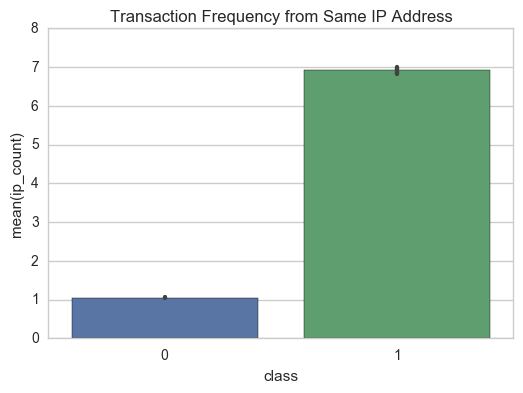

In [134]:
#get variable importance from random forest
importance = [abs(x) for x in clf.coef_[0]]
importance = list(zip(list(df.columns[1:]),importance))
importance = sorted(importance, key=lambda x: x[1])
importance = importance[::-1]
print('Importance:')
for imp in importance:
    print(str(imp[0])+' = '+str(imp[1]))

#test significance
dfsplit = [rows for _, rows in df.groupby('class')]
t, p = ttest_ind(dfsplit[0]['ip_count'], dfsplit[1]['ip_count'], equal_var=False)
print('\n\n==========================\n\n')
print("T-Test:")
print("p: "+str(p))
print("\n\n")

#plot most important variables
plt.figure()
sns.barplot(x="class", y="ip_count", data=df)
sns.plt.title('Transaction Frequency from Same IP Address')
plt.show()
plt.figure()


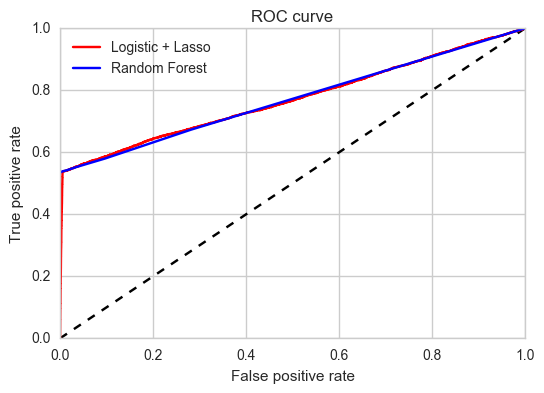

In [83]:
#plot ROC curve
clf_fpr, clf_tpr, clf_auc = roc_curve(Y_test, clf_y_score)
rf_fpr, rf_tpr, rf_auc = roc_curve(Y_test, rf_y_score)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(clf_fpr, clf_tpr, 'r', label='Logistic + Lasso')
plt.plot(rf_fpr, rf_tpr, 'b', label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()